In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Стекинг

Использовать стекинг в sklearn очень просто:

In [2]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = load_iris(return_X_y=True)

# Create Base Learners
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('rf_2', KNeighborsClassifier(n_neighbors=5))
                ]

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Extract score
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315

# Беггинг. Random Forest

Мотивацию построения алгоритма случайного леса (Random Forest) удобно рассматривать в терминах смещения и дисперсии. Начнём с построения решающего дерева.

In [ ]:
# !pip install mlxtend==0.22.0

In [36]:
# Пример отсюда: http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/

from sklearn.model_selection import train_test_split
from mlxtend.data import boston_housing_data

X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    shuffle = True)

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print('MSE train:', mean_squared_error(y_train, y_pred_train))
print('MSE test:', mean_squared_error(y_test, y_pred_test))

MSE train: 0.0
MSE test: 22.84


In [38]:
from mlxtend.evaluate import bias_variance_decomp

_, bias, variance = bias_variance_decomp(dt, X_train, y_train, X_test, y_test, loss = 'mse')

In [39]:
bias

8.833806794117644

In [40]:
variance

12.328421637254902

Как мы обсуждали на предыдущем семинаре, такое дерево окажется сильно переобученным (высокая дисперсия и низкое смещение). Постараемся исправить это. На лекции мы обсуждали, что один из способов борьбы с переобучением – построение композиций моделей. На этом семинаре мы рассмотрим построение композиций при помощи бэггинга.

#### Бэггинг

Вспомним суть алгоритма:

1. Обучаем много деревьев на бутстрапированных подвыборках исходной выборки независимо друг от друга. Бутстрапированную подвыборку строим при помощи выбора $N$ (размер исходной выборки) наблюдений из исходной выборки с возвращением.

2. Усредняем предсказания всех моделей (например, берём арифметическое среднее).

Можно показать, что модель, построенная при помощи бэггинга, будет иметь **то же смещение**, что и у отдельных деревьев, но значительно **меньшую дисперсию** (при выполнении некоторых условий).

In [41]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

base_tree = DecisionTreeRegressor(random_state=42)

bagging = BaggingRegressor(base_tree, n_estimators=20)
bagging.fit(X_train, y_train)

_, bias, variance = bias_variance_decomp(bagging, X_train, y_train, X_test, y_test, loss='mse')
bias, variance

(9.141440676109058, 2.6847962981556375)

Как мы видим, по сравнению с единичным деревом смещение практически не изменилось, но дисперсия уменьшилась в несколько раз!

Посмотрим, как это отразилось на среднеквадратичной ошибке.

In [42]:
ypred_test = bagging.predict(X_test)
ypred_train = bagging.predict(X_train)
print(mean_squared_error(y_train, ypred_train), mean_squared_error(y_test, ypred_test))

6.9750050742574246 11.609928921568626


#### Случайный лес

При построении каждого дерева в бэггинге в ходе создания очередного узла будем

выбирать случайный набор признаков, на основе которых производится разбиение. В результате такой процедуры мы уменьшим корреляцию между деревьями, за счёт чего снизим дисперсию итоговой модели. Такой алгоритм назвывается **случайным лесом** (Random Forest).

По сравнению с единичным деревом к параметрам случайного леса добавляются:
- `max_features` – число признаков, на основе которых проводятся разбиения при построении дерева.

- `n_estimators` – число деревьев.

Естественно, все параметры, относящиеся к единичному дереву, сохраняются для случайного леса.

In [43]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, random_state=42)

_, bias, variance = bias_variance_decomp(rf, X_train, y_train, X_test, y_test, loss = 'mse')
print(bias, variance)

ypred_test = rf.predict(X_test)
ypred_train = rf.predict(X_train)
print(mean_squared_error(y_train, ypred_train), mean_squared_error(y_test, ypred_test))

9.540158697898288 2.7650637788174017
6.466787376237622 16.612437745098042


#### OOB Error

Как мы обсудили выше, при построении случайного леса каждое дерево строится на бутстрапированной подвыборке, полученной из исходной обучающей выборки случайным набором с повторениями. Понятно, что некоторые наблюдения попадут в такую подвыборку несколько раз, а некоторые не войдут в неё вообще. Для каждого дерева можем рассмотреть объекты, которые не участвовали в обучении и использовать их для валидации.

Усреднённая ошибка на неотобранных образцах по всему случайному лесу называется **out-of-bag-ошибкой**.

In [ ]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# oob_score_ = R2 на не виденных наблюдениях
rf = RandomForestRegressor(n_estimators = 100, random_state = 123, oob_score = True, n_jobs=-1)
rf.fit(X_train, y_train)
rf.oob_score_

0.8760889947613861

In [ ]:
pred = rf.predict(X_test)

from sklearn.metrics import r2_score

r2_score(y_test, pred)

0.8253137316695912

# Бустинг

In [44]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.9 MB/s eta 0:00:00


## <font color='blue'>XGBoost</font> eXtreme Gradient Boosting

### https://github.com/dmlc/xgboost

### Пример

Возьмем датасет Boston Housing и обучим XGBoost на нем.

In [45]:
import xgboost as xgb

xgb.__version__

'2.0.3'

In [46]:
!wget https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/04-ClassificationTrees/Boston.csv

--2024-04-01 06:03:04--  https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/04-ClassificationTrees/Boston.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36137 (35K) [text/plain]
Saving to: ‘Boston.csv.1’

Boston.csv.1        100%[===================>]  35.29K  --.-KB/s    in 0.004s  

2024-04-01 06:03:04 (8.92 MB/s) - ‘Boston.csv.1’ saved [36137/36137]



In [47]:
from xgboost import XGBClassifier, XGBRegressor
import warnings

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error


rng = np.random.RandomState(31337)

data = pd.read_csv('Boston.csv')
X = data.drop('medv', axis=1)
y = data.medv

kf = KFold(n_splits=2, shuffle=True, random_state=rng)

XGBoost предлагает 2 способа использования алгоритмов:
* sklearn-совместимые классы XGBClassifier, XGBRegressor

* "оригинальная" python-библиотека

###  sklearn

In [48]:
# добавила iloc

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X.iloc[test_index])
    actuals = y.iloc[test_index]
    print("RMSE on fold {}: {}".format(fold_index, np.sqrt(mean_squared_error(actuals, predictions))))
    # ручная кросс-валидация

RMSE on fold 0: 4.799892433216096
RMSE on fold 1: 3.0661628783112866


### xgboost python

In [49]:
def get_params():
    params = {}
    params["objective"] = "reg:squarederror"
    params["booster"] = "gbtree"
    params["eval_metric"] = "rmse"
    params["max_depth"] = 3
    params["tree_method"] = "approx"
    params["sketch_eps"] = 1

    return params

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

    params = get_params()

    xgtrain = xgb.DMatrix(X.iloc[train_index], label=y.iloc[train_index])
    xgtest = xgb.DMatrix(X.iloc[test_index], label=y.iloc[test_index])

    bst = xgb.train(params, xgtrain) #аналог fit в sklearn

    print("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))

RMSE on fold 0: [0]	eval-rmse:3.55490129052246573
RMSE on fold 1: [0]	eval-rmse:4.41588223659762669


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:03:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sketch_eps" } are not used.

  warnings.warn(smsg, UserWarning)


#### Пропуски в данных

XGBoost умеет обрабатывать разреженные матрицы

Но категориальные признаки нужно приводить к числовому виду

Нужно указать, какое число является "пропуском"

При сплите, алгоритм смотрит в какую сторону лучше отвести объекты с пропуском.

In [50]:
xgtrain_missed = xgb.DMatrix(X.iloc[test_index], label=y.iloc[test_index], missing=-999.0)

#### Feature importances

Подсчитывает, сколько раз каждый признак использовался для использовался в вершине дерева при разбиении

Это не качество фактора, а его важность

In [51]:
bst.get_fscore()

{'crim': 9.0,
 'zn': 1.0,
 'indus': 1.0,
 'chas': 1.0,
 'nox': 4.0,
 'rm': 16.0,
 'age': 4.0,
 'dis': 6.0,
 'rad': 1.0,
 'tax': 3.0,
 'ptratio': 4.0,
 'black': 1.0,
 'lstat': 16.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1200x1200 with 0 Axes>

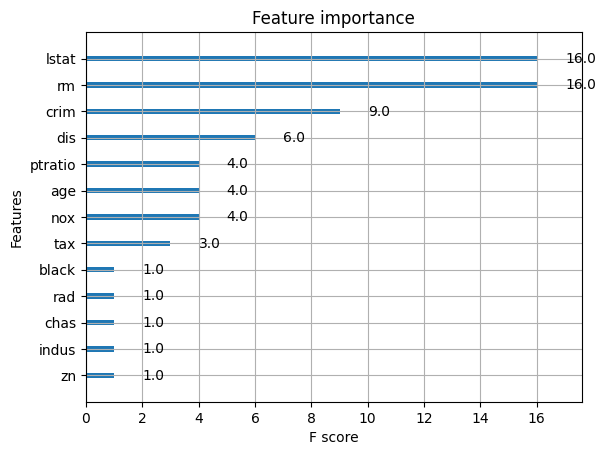

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
xgb.plot_importance(bst)

## LightGBM. Пример решения задачи.

In [53]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore")
#    data = load_boston()
#X_full = data.data
#y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100,
                                        random_state=241)

Обучение

In [54]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1')

Starting training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 13
[LightGBM] [Info] Start training from score 22.746305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

LGBMRegressor(learning_rate=0.05, n_estimators=20)

Предсказание и оценка качества

In [55]:
print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Starting predicting...
The rmse of prediction is: 5.259625962258064
Feature importances: [35, 0, 6, 0, 20, 70, 21, 31, 3, 7, 15, 4, 83]


Можно задать любую метрику качества - надо написать свою функцию.

In [56]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Starting training with custom eval function...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 13
[LightGBM] [Info] Start training from score 22.746305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Подбор гиперпараметров.

In [57]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 12
[LightGBM] [Info] Start training from score 22.805926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Предсказание и оценка качества

In [58]:
pred = gbm.predict(X_test)

In [59]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

12.703535974721541

## CatBoost

In [60]:
import catboost
print(catboost.__version__)

1.2.3


Считываем данные

In [61]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

https://www.kaggle.com/c/amazon-employee-access-challenge/data

In [62]:
(train_df, test_df) = catboost.datasets.amazon()

In [63]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Подготовка данных

In [64]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

In [65]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [66]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


In [67]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.
train_df.to_csv(
    os.path.join(dataset_dir, 'train.tsv'),
    index=False, sep='\t', header=False
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.tsv'),
    index=False, sep='\t', header=False
)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

Обучение

In [69]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


Печать результатов обучения

In [70]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=150,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose = 3
)

Learning rate set to 0.162066
0:	learn: 0.5765572	test: 0.5766422	best: 0.5766422 (0)	total: 50.5ms	remaining: 7.52s
3:	learn: 0.3828682	test: 0.3830266	best: 0.3830266 (3)	total: 241ms	remaining: 8.81s
6:	learn: 0.2952615	test: 0.2952535	best: 0.2952535 (6)	total: 305ms	remaining: 6.22s
9:	learn: 0.2478728	test: 0.2483678	best: 0.2483678 (9)	total: 413ms	remaining: 5.78s
12:	learn: 0.2193492	test: 0.2180675	best: 0.2180675 (12)	total: 514ms	remaining: 5.42s
15:	learn: 0.2007458	test: 0.1970088	best: 0.1970088 (15)	total: 566ms	remaining: 4.74s
18:	learn: 0.1901703	test: 0.1840867	best: 0.1840867 (18)	total: 628ms	remaining: 4.33s
21:	learn: 0.1836267	test: 0.1763071	best: 0.1763071 (21)	total: 701ms	remaining: 4.08s
24:	learn: 0.1806816	test: 0.1726814	best: 0.1726814 (24)	total: 775ms	remaining: 3.87s
27:	learn: 0.1770253	test: 0.1689148	best: 0.1689148 (27)	total: 871ms	remaining: 3.8s
30:	learn: 0.1750605	test: 0.1659663	best: 0.1659663 (30)	total: 929ms	remaining: 3.56s
33:	learn:

Вычисление метрик

In [71]:
from matplotlib import pylab as plt

from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

Наилучшее количество деревьев

In [72]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

In [73]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


Кросс-валидация

In [74]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.164632916
bestIteration = 48

Training on fold [2/5]

bestTest = 0.15425211
bestIteration = 35

Training on fold [3/5]

bestTest = 0.1433537051
bestIteration = 55

Training on fold [4/5]

bestTest = 0.1560519524
bestIteration = 55



In [75]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.227370,0.007679,0.228497,0.005126,0.642263,0.048004
2,2,0.190856,0.006917,0.196796,0.003999,0.791709,0.011361
3,3,0.178884,0.007455,0.186682,0.003242,0.813889,0.009362
4,4,0.172286,0.007957,0.181380,0.002135,0.826529,0.005319


In [76]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1582±0.0102 on step 53


In [77]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    inverted=False,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Training on fold [0/5]

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]

bestTest = 0.1597838545
bestIteration = 25

Training on fold [3/5]

bestTest = 0.1523066165
bestIteration = 56

Training on fold [4/5]

bestTest = 0.1577738401
bestIteration = 30

Best validation Logloss score, stratified: 0.1580±0.0041 on step 56


Детектор переобучения

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

In [ ]:
print(model_with_early_stop.tree_count_)

30


In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

In [ ]:
print(model_with_early_stop.tree_count_)

30


Выбор порога

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False
)

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

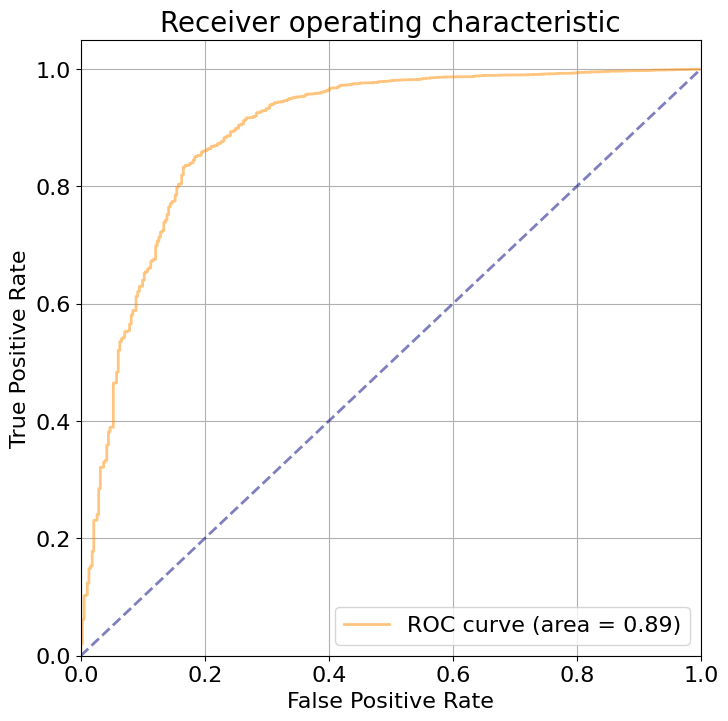

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

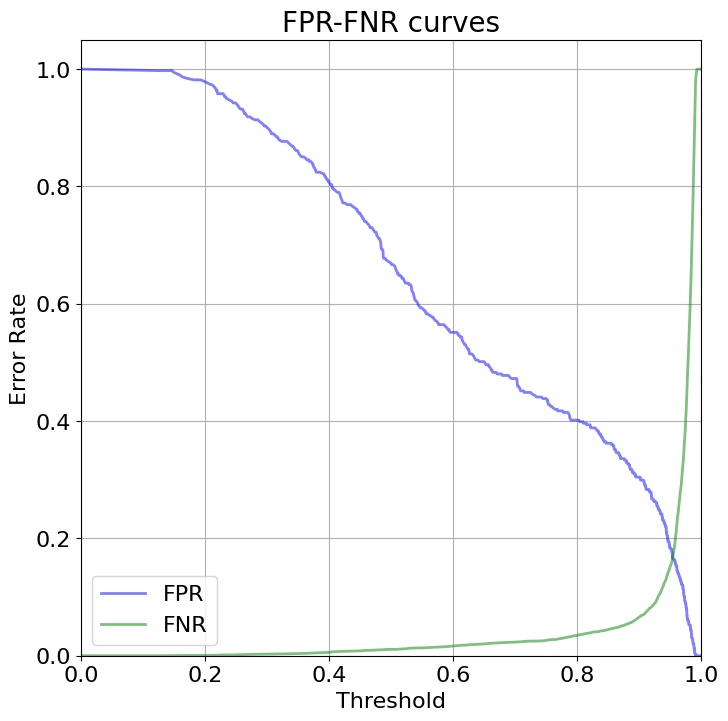

In [ ]:
plt.figure(figsize=(8, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.4805444481363058
0.9900857295557712


Предсказания модели

In [ ]:
print(model.predict_proba(X_validation))

[[0.0597 0.9403]
 [0.014  0.986 ]
 [0.0132 0.9868]
 ...
 [0.0163 0.9837]
 [0.0203 0.9797]
 [0.0332 0.9668]]


In [ ]:
print(model.predict(X_validation))

[1 1 1 ... 1 1 1]


In [ ]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[2.756  4.2541 4.312  ... 4.1022 3.8753 3.3723]


In [ ]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9403 0.986  0.9868 ... 0.9837 0.9797 0.9668]


Последовательные предсказания

In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0,
    ntree_end=5,
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4791 0.5209]
 [0.4791 0.5209]
 [0.4791 0.5209]
 ...
 [0.4791 0.5209]
 [0.4791 0.5209]
 [0.4791 0.5209]]
Iteration 1, predictions:
[[0.4581 0.5419]
 [0.4581 0.5419]
 [0.4581 0.5419]
 ...
 [0.4581 0.5419]
 [0.4581 0.5419]
 [0.4581 0.5419]]
Iteration 2, predictions:
[[0.4381 0.5619]
 [0.4381 0.5619]
 [0.4381 0.5619]
 ...
 [0.4381 0.5619]
 [0.4381 0.5619]
 [0.4381 0.5619]]
Iteration 3, predictions:
[[0.4185 0.5815]
 [0.4185 0.5815]
 [0.4185 0.5815]
 ...
 [0.4185 0.5815]
 [0.4185 0.5815]
 [0.4185 0.5815]]
Iteration 4, predictions:
[[0.398  0.602 ]
 [0.4044 0.5956]
 [0.4044 0.5956]
 ...
 [0.398  0.602 ]
 [0.398  0.602 ]
 [0.4044 0.5956]]


Многоклассовая классификация

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function='MultiClass'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

Важность признаков

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,MGR_ID,31.659932
1,RESOURCE,17.171955
2,ROLE_FAMILY_DESC,12.332457
3,ROLE_DEPTNAME,10.864216
4,ROLE_CODE,8.994698
5,ROLE_ROLLUP_2,8.847865
6,ROLE_ROLLUP_1,5.537394
7,ROLE_TITLE,2.484312
8,ROLE_FAMILY,2.107171


Сохранение модели

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


#### Настройка гиперпараметров

Скорость обучения

In [ ]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False
)

Точность

In [ ]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation)
)

# Задание

Решите задачу с данными train_small.csv, test_small.csv с помощью CatBoost, xgboost и LightGBM. Найдите оптимальные параметры. Сравните скорость обучения и качество.

In [23]:
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')

ytrain = X_train['Disbursed']
Xtrain = X_train.copy()
del Xtrain['Disbursed']

ytest = X_test['Disbursed']
Xtest = X_test.copy()
del Xtest['Disbursed']

In [ ]:
# xgboost

In [38]:
import pandas as pd
data = pd.read_csv('train_small.csv')
data.head()

,Unnamed: 0,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed
0,8161,0.0,250000.0,5.0,23200,2,3,28,1,1,...,0,0,0,0,0,1,0,1,0,0.0
1,77530,0.0,0.0,0.0,25000,0,0,33,1,1,...,0,0,0,1,0,1,1,0,0,0.0
2,80633,0.0,0.0,0.0,95000,3,7,39,1,1,...,0,0,0,1,0,1,1,0,0,0.0
3,45059,0.0,0.0,0.0,29880,5,3,28,0,0,...,0,0,0,0,0,1,0,1,0,0.0
4,54857,4500.0,100000.0,3.0,30000,5,10,26,0,0,...,0,0,0,1,0,1,1,0,0,0.0


In [25]:
data = pd.read_csv('test_small.csv')
data.head()

,Unnamed: 0,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed
0,35478,0.0,300000.0,5.0,34000,3,10,32,0,0,...,0,0,0,0,0,1,0,1,0,1.0
1,68483,0.0,160000.0,0.0,23000,7,0,31,1,1,...,0,0,0,1,1,0,1,0,0,0.0
2,74927,0.0,200000.0,4.0,13000,4,1,27,0,0,...,0,0,0,1,0,1,1,0,0,0.0
3,83034,5000.0,500000.0,5.0,50000,5,16,29,0,0,...,0,0,0,1,0,1,1,0,0,0.0
4,82929,9000.0,300000.0,0.0,28500,4,8,30,0,0,...,0,0,0,1,0,1,1,0,0,0.0


In [26]:
!pip install xgboost

In [27]:
import xgboost as xgb

In [28]:
from xgboost import XGBClassifier, XGBRegressor
import warnings

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error
rng = np.random.RandomState(31337)

In [29]:
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')

y_train = X_train['Disbursed']
#X_train = X_train.copy()
#del Xtrain['Disbursed']
X_train = X_train.drop('Disbursed', axis=1)

y_test = X_test['Disbursed']
#X_test = X_test.copy()
#del Xtest['Disbursed']
X_test = X_test.drop('Disbursed', axis=1)

kf = KFold(n_splits=2, shuffle=True, random_state=rng)

In [31]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(Xtest)
print(np.sqrt(mean_squared_error(ytest, predictions)))

0.12911157040216278


In [ ]:
# Второй вариант использования xgboost - реализация через python. Как и выше, в тренировочных заданиях, добавила iloc

In [32]:
def get_params():
    params = {}
    params["objective"] = "reg:squarederror"
    params["booster"] = "gbtree"
    params["eval_metric"] = "rmse"
    params["max_depth"] = 3
    params["tree_method"] = "approx"
    params["sketch_eps"] = 1

    return params

for fold_index, (train_index, test_index) in enumerate(kf.split(X_train)):

    params = get_params()

    xgtrain = xgb.DMatrix(X_train.iloc[train_index], label=y_train.iloc[train_index])
    xgtest = xgb.DMatrix(X_train.iloc[test_index], label=y_train.iloc[test_index])

    bst = xgb.train(params, xgtrain)

    print("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))

RMSE on fold 0: [0]	eval-rmse:0.12326817596838291
RMSE on fold 1: [0]	eval-rmse:0.11744557458160637


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:41:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sketch_eps" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Feature impotrance

In [33]:
bst.get_fscore()

{'Unnamed: 0': 10.0,
 'Existing_EMI': 9.0,
 'Loan_Amount_Applied': 4.0,
 'Loan_Tenure_Applied': 2.0,
 'Monthly_Income': 16.0,
 'Var4': 1.0,
 'Var5': 10.0,
 'Device_Type_0': 1.0,
 'Filled_Form_0': 1.0,
 'Var1_2': 3.0,
 'Var1_3': 5.0,
 'Var1_8': 2.0,
 'Var1_11': 1.0,
 'Var2_2': 3.0,
 'Var2_5': 1.0,
 'Source_1': 1.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1200x1200 with 0 Axes>

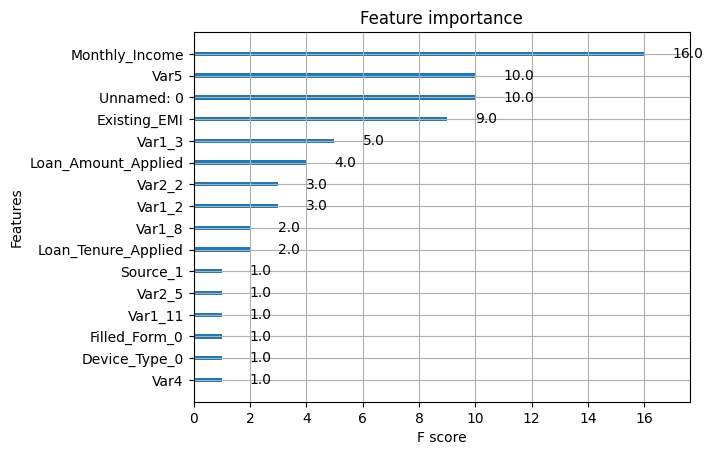

In [34]:
# график важности признаков

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
xgb.plot_importance(bst)

In [ ]:
# lightgbm

In [35]:
!pip install lightgbm

In [36]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100,
                                        random_state=241)

In [60]:
# обучение

print('Starting training...')

gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1')

Starting training...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 4
[LightGBM] [Info] Start training from score 1.240000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMRegressor(learning_rate=0.05, n_estimators=20)

In [61]:
# Предсказание и оценка качества

print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Starting predicting...
The rmse of prediction is: 0.574612469163865
Feature importances: [0, 0, 16, 4]


In [62]:
# Подбор гиперпараметров

estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'n_estimators': [20, 30, 40, 80, 100]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 33, number of used features: 0
[LightGBM] [Info] Start training from score 1.212121
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

In [63]:
pred = gbm.predict(X_test)

In [64]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

0.6392876725137773

In [ ]:
# catboost

In [65]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.8 MB/s eta 0:00:00


In [66]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from sklearn.model_selection import train_test_split

In [73]:
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
y_train = X_train['Disbursed']
X_train = X_train.drop('Disbursed', axis=1)
y_test = X_test['Disbursed']
X_test = X_test.drop('Disbursed', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=1234)

In [74]:
cat_features = list(range(0, X_train.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [75]:
print('Labels_train: {}'.format(set(y_train)))

print('Zero count = {}, One count = {}'.format(len(y_train) - sum(y_train), sum(y_train)))

print('Labels_test: {}'.format(set(y_test)))

print('Zero count = {}, One count = {}'.format(len(y_test) - sum(y_test), sum(y_test)))

Labels_train: {0.0, 1.0}
Zero count = 19212.0, One count = 280.0
Labels_test: {0.0, 1.0}
Zero count = 4787.0, One count = 86.0


In [76]:
# обучение

from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


In [77]:
# печать результатов обучения

from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=150,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose = 3
)

Learning rate set to 0.150627
0:	learn: 0.3988869	test: 0.4036399	best: 0.4036399 (0)	total: 9.59ms	remaining: 1.43s
3:	learn: 0.1316899	test: 0.1401005	best: 0.1401005 (3)	total: 30.3ms	remaining: 1.1s
6:	learn: 0.0832499	test: 0.0933538	best: 0.0933538 (6)	total: 52.5ms	remaining: 1.07s
9:	learn: 0.0707373	test: 0.0822224	best: 0.0822224 (9)	total: 73.9ms	remaining: 1.03s
12:	learn: 0.0657016	test: 0.0786794	best: 0.0786794 (12)	total: 94.9ms	remaining: 1000ms
15:	learn: 0.0632711	test: 0.0776919	best: 0.0776919 (15)	total: 119ms	remaining: 996ms
18:	learn: 0.0617578	test: 0.0776984	best: 0.0776043 (16)	total: 141ms	remaining: 969ms
21:	learn: 0.0607817	test: 0.0775272	best: 0.0775272 (21)	total: 164ms	remaining: 954ms
24:	learn: 0.0597296	test: 0.0773295	best: 0.0773295 (24)	total: 185ms	remaining: 927ms
27:	learn: 0.0589045	test: 0.0769950	best: 0.0769950 (27)	total: 209ms	remaining: 912ms
30:	learn: 0.0580589	test: 0.0769516	best: 0.0769516 (30)	total: 231ms	remaining: 885ms
33:	l

In [78]:
# Вычисление метрик качества

from matplotlib import pylab as plt
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [80]:
# Количество деревьев

from catboost import CatBoostClassifier
model = CatBoostClassifier(
  iterations=100,
  random_seed=63,
  learning_rate=0.5,
  use_best_model=False
)
model.fit(
  X_train, y_train,
  eval_set=(X_test, y_test),
  verbose=False
)

In [81]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 100


In [89]:
# Кросс-валидация

from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 90
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.05

cv_data = cv(
    params = params,
    pool = Pool(X_train, label=y_train),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 0.06175893412
bestIteration = 89

Training on fold [1/5]

bestTest = 0.07438357985
bestIteration = 89

Training on fold [2/5]

bestTest = 0.05546334303
bestIteration = 89

Training on fold [3/5]

bestTest = 0.06987191424
bestIteration = 89

Training on fold [4/5]

bestTest = 0.06440602758
bestIteration = 88



In [90]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.0652±0.0073 on step 89


In [93]:
# Детектор переобучения

model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [94]:
print(model_with_early_stop.tree_count_)

18


In [96]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [97]:
print(model_with_early_stop.tree_count_)

23


In [98]:
# Выбор порога

model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    verbose=False
)

In [99]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_test, y_test)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

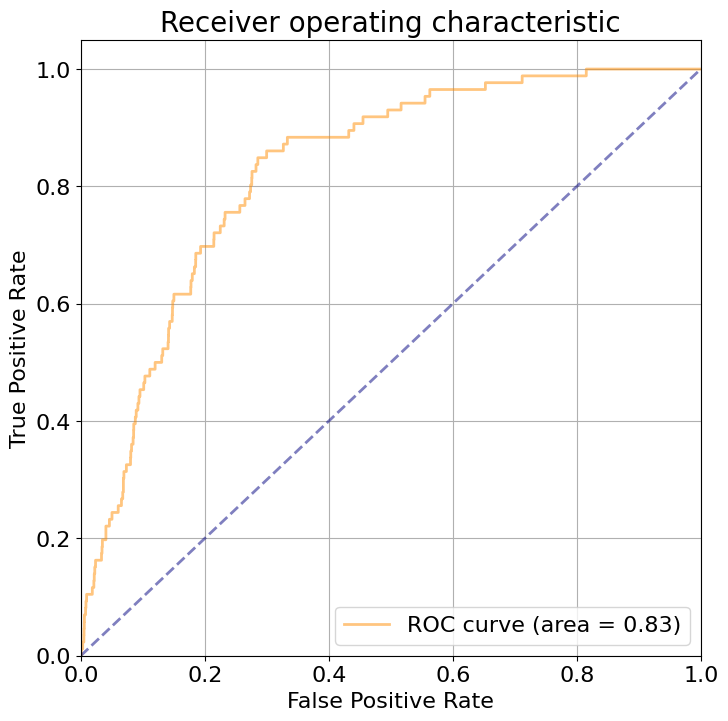

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [101]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

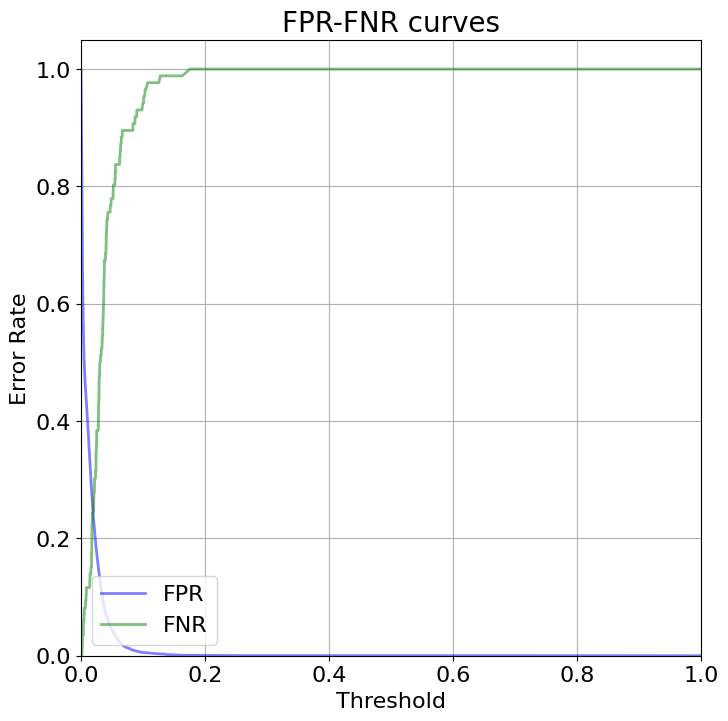

In [102]:
plt.figure(figsize=(8, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [103]:
from catboost.utils import select_threshold
print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.00188714846646718
0.0827651696509994


In [104]:
# Предсказания модели

print(model.predict_proba(X_test))

[[0.9902 0.0098]
 [0.958  0.042 ]
 [0.9903 0.0097]
 ...
 [0.9334 0.0666]
 [0.9954 0.0046]
 [0.9957 0.0043]]


In [105]:
print(model.predict(X_test))

[0. 0. 0. ... 0. 0. 0.]


In [106]:
raw_pred = model.predict(
    data=X_test,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[-4.6118 -3.1265 -4.628  ... -2.6404 -5.3738 -5.4376]


In [107]:
from numpy import exp
sigmoid = lambda x: 1 / (1 + exp(-x))
probabilities = sigmoid(raw_pred)
print(probabilities)

[0.0098 0.042  0.0097 ... 0.0666 0.0046 0.0043]


# Задание

Решите задачу классификации пассажиров Титаника с помощью любого из ансамблей (или нескольких из них). Если у вас есть наработки по Титанику, используйте их.

Удалось ли улучшить качество с помощью какого-либо из этих алгоритмов?

In [82]:
import pandas as pd

data = pd.read_csv("titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
def mf(s):
  return int(s == 'female')

data['Sex'] = data['Sex'].apply(mf)

In [84]:
data.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True) # удаляем имена и индивидуальные номера, номера кают ('Cabin') - слишком много пустых строк

In [85]:
categ_columns = data.select_dtypes(['object']).columns
data[categ_columns] = data[categ_columns].apply (lambda x: pd.factorize(x)[0])

In [86]:
data = data.fillna(data.mean())

In [87]:
data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,0
1,1,1,1,38.000000,1,0,71.2833,1
2,1,3,1,26.000000,0,0,7.9250,0
3,1,1,1,35.000000,1,0,53.1000,0
4,0,3,0,35.000000,0,0,8.0500,0
5,0,3,0,29.699118,0,0,8.4583,2
6,0,1,0,54.000000,0,0,51.8625,0
7,0,3,0,2.000000,3,1,21.0750,0
8,1,3,1,27.000000,0,2,11.1333,0
9,1,2,1,14.000000,1,0,30.0708,1


In [109]:
X = data.drop('Survived', axis=1)
y = data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [110]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [113]:
# Для начала просто посмотрела регрессию

from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)
print(classification_report(ypred_train, y_train), classification_report(ypred_test, y_test))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       392
           1       0.77      0.71      0.74       276

    accuracy                           0.79       668
   macro avg       0.79      0.78      0.78       668
weighted avg       0.79      0.79      0.79       668
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       123
           1       0.83      0.71      0.76       100

    accuracy                           0.80       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.80      0.80       223



In [ ]:
# Беггинг

In [133]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from mlxtend.evaluate import bias_variance_decomp
import numpy as np

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print('MSE train:', mean_squared_error(y_train, y_pred_train))
print('MSE test:', mean_squared_error(y_test, y_pred_test))

MSE train: 0.009017678927858569
MSE test: 0.2287910679967054


In [135]:
base_tree = DecisionTreeRegressor(random_state=42)

bagging = BaggingRegressor(base_tree, n_estimators=20)
bagging.fit(X_train, y_train)

X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values
_, bias, variance = bias_variance_decomp(bagging, X_train_array, y_train_array, X_test_array, y_test_array, loss='mse')

bias, variance

(0.1313615027391739, 0.025291418042983307)

In [132]:
ypred_test = bagging.predict(X_test)
ypred_train = bagging.predict(X_train)
print(mean_squared_error(y_train, ypred_train), mean_squared_error(y_test, ypred_test))

0.07139478786132855 0.16357255698804185


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


In [137]:
# Итоговое влияние на среднеквадратичную ошибку

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, random_state=42)

_, bias, variance = bias_variance_decomp(rf, X_train_array, y_train_array, X_test_array, y_test_array, loss = 'mse')
print(bias, variance)

ypred_test = rf.predict(X_test)
ypred_train = rf.predict(X_train)
print('MSE train:', mean_squared_error(y_train, ypred_train))
print('MSE test:', mean_squared_error(y_test, ypred_test))

0.13337906303485209 0.02564718636632633
MSE train: 0.0731827267088729
MSE test: 0.160322140677195


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
# Стекинг

In [138]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [139]:
# Сначала алгоритмы и их качество по отдельности, потом вместе

KNN = KNeighborsClassifier()
model_KNeighborsClassifier = KNN.fit(X_train, y_train)
pred_knn = model_KNeighborsClassifier.predict(X_test)

In [140]:
acc_knn = accuracy_score(y_test, pred_knn)
print('accuracy for KNN:', acc_knn)

accuracy for KNN: 0.7309417040358744


In [141]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(random_state=24)
model_DecisionTreeClassifier = DT.fit(X_train, y_train)
pred_dt = model_DecisionTreeClassifier.predict(X_test)

In [142]:
acc_dt = accuracy_score(y_test, pred_dt)
print('accuracy for DT:', acc_dt)

accuracy for DT: 0.7802690582959642


In [143]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
RF = RandomForestClassifier(n_estimators=10, random_state=42)
model_RandomForestClassifier = RF.fit(X_train, y_train)
pred_rf = model_RandomForestClassifier.predict(X_test)

In [144]:
acc_rf = accuracy_score(y_test, pred_rf)
print('accuracy for RF:', acc_rf)

accuracy for RF: 0.8116591928251121


In [124]:
# результат для ансамбля

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('rf_2', KNeighborsClassifier(n_neighbors=5))
                ]
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
clf.fit(X_train, y_train).score(X_test, y_test)

0.8116591928251121

In [ ]:
# Бустинг (xgboost)

In [145]:
import xgboost as xgb

In [146]:
from xgboost import XGBClassifier, XGBRegressor
import warnings

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error


rng = np.random.RandomState(31337)

X = data.drop('Survived', axis=1)
y = data.Survived

kf = KFold(n_splits=2, shuffle=True, random_state=rng)

In [147]:
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X.iloc[test_index])
    actuals = y.iloc[test_index]
    print("RMSE on fold {}: {}".format(fold_index, np.sqrt(mean_squared_error(actuals, predictions))))

RMSE on fold 0: 0.3930882965808335
RMSE on fold 1: 0.4173508847359173


In [ ]:
# В других вариантах бустинга были похожие варианты